In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
import torchsummary
from torchvision import transforms
import time
from sklearn.metrics import classification_report

In [3]:
label_data=np.loadtxt('/home/sumins/workspace/washout classification/equal_slice/label_train.txt',dtype=int)
label_data=label_data.tolist()
label_datat=np.loadtxt('/home/sumins/workspace/washout classification/equal_slice/label_test.txt',dtype=int)
label_datat=label_datat.tolist()

In [4]:
data_path='/home/sumins/workspace/washout classification/equal_slice/channel4_train.nii'
channel4=[]
total=nib.load(data_path).get_fdata()
totalslice=total.shape[0]  

for i in range(0,totalslice):
    channel4.append(total[i,:,:,:])


data_patht='/home/sumins/workspace/washout classification/equal_slice/channel4_test.nii'
channel4t=[]
totalt=nib.load(data_patht).get_fdata()
totalslicet=totalt.shape[0]  

for i in range(0,totalslicet):
    channel4t.append(totalt[i,:,:,:])

In [5]:
print(len(channel4))
print(len(channel4t))

1347
293


In [6]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    npy -= GLOBAL_PIXEL_MEAN
    
    npy=npy.astype(dtype='float32')
    if self.transforms is not None:
      npy=self.transforms(npy)
    
    return{'npy':npy,'label':self.all_labels[idx]}

In [7]:
transforms_train = transforms.Compose([transforms.ToTensor()
                                       ])
transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])


In [44]:
class CustomConvNet(nn.Module):
    def __init__(self):
        super(CustomConvNet, self).__init__() #상속받은 class에 접근하기 위함

        self.layer1 = self.conv_module(4, 16) #흑백사진은 inp
        self.layer2 = self.conv_module(16, 32)
        self.layer3 = self.conv_module(32, 64)
        self.layer4 = self.conv_module(64, 128)
        self.layer5 = self.conv_module(128, 256)
        self.gap = self.global_avg_pool(256, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, 2)

        return out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)))
        
model=CustomConvNet()
torchsummary.summary(model.cuda(),input_size=(4,512,512),batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 16, 512, 512]             592
       BatchNorm2d-2          [4, 16, 512, 512]              32
         LeakyReLU-3          [4, 16, 512, 512]               0
         MaxPool2d-4          [4, 16, 256, 256]               0
            Conv2d-5          [4, 32, 256, 256]           4,640
       BatchNorm2d-6          [4, 32, 256, 256]              64
         LeakyReLU-7          [4, 32, 256, 256]               0
         MaxPool2d-8          [4, 32, 128, 128]               0
            Conv2d-9          [4, 64, 128, 128]          18,496
      BatchNorm2d-10          [4, 64, 128, 128]             128
        LeakyReLU-11          [4, 64, 128, 128]               0
        MaxPool2d-12            [4, 64, 64, 64]               0
           Conv2d-13           [4, 128, 64, 64]          73,856
      BatchNorm2d-14           [4, 128,

In [45]:
hyper_param_epoch=200
hyper_param_batch=8
hyper_param_learning_rate=0.0001

In [46]:
train_dataset=CustomDataset(volume_list=channel4, all_labels=label_data,transforms=transforms_train)
train_loader = DataLoader(train_dataset, batch_size=hyper_param_batch, shuffle=True)
test_dataset=CustomDataset(volume_list=channel4t, all_labels=label_datat,transforms=transforms_train)
test_loader = DataLoader(test_dataset, batch_size=hyper_param_batch, shuffle=True)

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device,"/" ,torch.cuda.device_count())

custom_model=CustomConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=hyper_param_learning_rate)

cuda:0 / 1


In [48]:
def validation_loss(model):
    total_loss=0
    for i_batch, item in enumerate(test_loader):
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
 
        outputs =model(npys)
        loss = criterion(outputs, labels)

        total_loss+=loss.item()
    return total_loss/(i_batch+1)

In [49]:
loss_value=1
start=time.time()
custom_model.train()
train_loss_history=[]
valid_loss_history=[]
val_loss=0
for e in range(hyper_param_epoch):
        for i_batch, item in enumerate(train_loader):
                
                npys = item['npy'].to(device)
                labels = item['label'].to(device)
                #print(npys)
                # Forward pass
                outputs =custom_model(npys)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        val_loss=validation_loss(custom_model)
        train_loss_history.append(loss.item())
        valid_loss_history.append(val_loss)
        print('Epoch [{}/{}],i_batch={} ,Train_Loss: {:.4f},Valid_loss: {:.4f}'
                                        .format(e + 1, hyper_param_epoch, i_batch+1, loss.item(),val_loss))
        print("Time: {}sec".format(time.time()-start))
        start=time.time()
        if loss_value>val_loss:
                loss_value=val_loss
                torch.save({
                'epoch': e,
                'model_state_dict': custom_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, '/home/sumins/workspace/washout classification/model_save/equal2.pth')


Epoch [1/200],i_batch=169 ,Train_Loss: 0.5713,Valid_loss: 0.6613
Time: 96.05845475196838sec
Epoch [2/200],i_batch=169 ,Train_Loss: 0.7207,Valid_loss: 0.6556
Time: 108.2528727054596sec
Epoch [3/200],i_batch=169 ,Train_Loss: 0.8722,Valid_loss: 0.6426
Time: 113.8655059337616sec
Epoch [4/200],i_batch=169 ,Train_Loss: 0.5333,Valid_loss: 0.6507
Time: 108.03474020957947sec
Epoch [5/200],i_batch=169 ,Train_Loss: 0.6045,Valid_loss: 0.6515
Time: 95.86937165260315sec
Epoch [6/200],i_batch=169 ,Train_Loss: 0.5361,Valid_loss: 0.6488
Time: 98.48801374435425sec
Epoch [7/200],i_batch=169 ,Train_Loss: 0.6429,Valid_loss: 0.6425
Time: 109.52362942695618sec
Epoch [8/200],i_batch=169 ,Train_Loss: 0.5480,Valid_loss: 0.6467
Time: 107.63015007972717sec
Epoch [9/200],i_batch=169 ,Train_Loss: 0.5239,Valid_loss: 0.6516
Time: 103.85477066040039sec
Epoch [10/200],i_batch=169 ,Train_Loss: 0.3952,Valid_loss: 0.6590
Time: 96.11368918418884sec
Epoch [11/200],i_batch=169 ,Train_Loss: 0.5962,Valid_loss: 0.6376
Time: 95.

KeyboardInterrupt: 

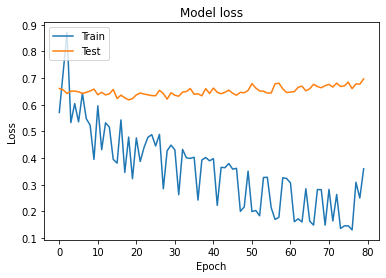

In [50]:
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

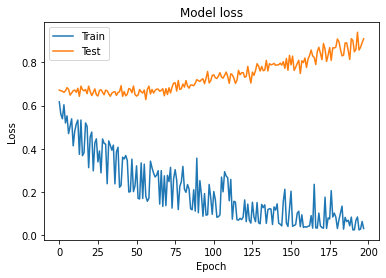

In [29]:
v=valid_loss_history[:]

t=train_loss_history[:]
del v[192]

del t[192]
del v[196]

del t[196]
plt.plot(t)
plt.plot(v)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
import csv


with open("v_loss_equal.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(valid_loss_history)
with open("t_loss_equal.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(train_loss_history)

In [51]:
true_label=[]
pred_label=[]

model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/equal2.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(epoch)
print(loss)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)
        total += len(labels)
       
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

18
tensor(0.4788, device='cuda:0', requires_grad=True)
Test Accuracy of the model on the 293 test images: 73.37883959044369 %


In [52]:
true_labels=torch.tensor(true_label)
true_labels=true_labels.tolist()
pred_labels=torch.tensor(pred_label)
pred_labels=pred_labels.tolist()
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.91      0.22      0.35        97
           1       0.72      0.99      0.83       196

    accuracy                           0.73       293
   macro avg       0.82      0.60      0.59       293
weighted avg       0.78      0.73      0.67       293



In [53]:
true_label=[]
pred_label=[]

model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/equal2.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(epoch)
print(loss)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in train_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)
        total += len(labels)
       
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

18
tensor(0.4788, device='cuda:0', requires_grad=True)
Test Accuracy of the model on the 1347 test images: 98.96065330363771 %


In [54]:
true_labels=torch.tensor(true_label)
true_labels=true_labels.tolist()
pred_labels=torch.tensor(pred_label)
pred_labels=pred_labels.tolist()
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       299
           1       0.99      0.99      0.99      1048

    accuracy                           0.99      1347
   macro avg       0.99      0.98      0.98      1347
weighted avg       0.99      0.99      0.99      1347

